##  <center> Auto Insurance </center>

Il s'agira dans ce projet d'implementer un modèle de classification binaire de la variable TARGET_FLAG correspondant au fait qu'un assuré ait fait ou pas une demande d'indemnisation 
###  <center> Joel Mbouwe </center>

Le notebook est structuré comme suit :

- Le jeu de données sera initialiement chargé et nettoyé 
- Une analyse rapide des variables et notamment de leur corrélation avec la variable cible sera ensuite faite
- Les données seront séparées en données d'entraînement et de validation et plusieurs modèles de ML seront calibrés sur le training set et validés sur le val set
- Le meilleur modèle sera finalement re-entraîné sur l'intégralité du jeu de données et appliqué sur les données test. Les prédictions seront sauvegardées sous format CSV

#### Import des packages et fonctions utilitaires

In [1]:
import warnings; warnings.simplefilter("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from IPython.display import display
sns.set(style="ticks", color_codes=True)

In [2]:
def plot_cat_distribution(df, ord_cols, n_left = 3, 
                          n_right = 4, figsize = (15, 12)) :
    
    """
    Fonction utilitaire permettant d'évaluer la distribution de la variable cible
    dans chaque modalité prise par une variables catégorielle
    """
    fig, axes = plt.subplots(n_left, n_right, figsize=figsize)
    for i, ax in enumerate(fig.axes):
        if i < len(ord_cols):
            col = ord_cols[i]
            if col != 'TARGET_FLAG' : 
                prop_df = (df[col]
               .groupby(df['TARGET_FLAG'])
               .value_counts(normalize=True)
               .rename('prop')
               .reset_index())
                sns.barplot(x=col, y='prop', hue='TARGET_FLAG', data=prop_df, ax=ax)
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
    fig.tight_layout()

#### Analyse des données d'entraînement

In [3]:
data_train = pd.read_csv("train_auto.csv")
data_train.drop(columns=["INDEX", "TARGET_AMT"], inplace=True)
columns = data_train.columns
print(columns)

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


Les variables INDEX ET TARGET_AMT sont retirées du jeu de données.

In [4]:
print(columns)

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


In [5]:
data_train.head(2)

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban


In [6]:
print(data_train.shape)

(8161, 24)


In [7]:
## Nettoyage des variables contenant des $
def clean_amount_col(x):
    """
    Fonction convertissant en float les variables contenant des $
    """
    try :
        if x[0] == "$" :
            return float(x.replace("$", '').replace(",", "."))
        return float(x)
    except :
        return np.nan
for col in ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"] :
    data_train[col] = data_train[col].apply(clean_amount_col)

Les graphes ci après representent, pour une variable catégorielle, la proportion des classes à prédire dans chaque modalité de la variable catégorielle.


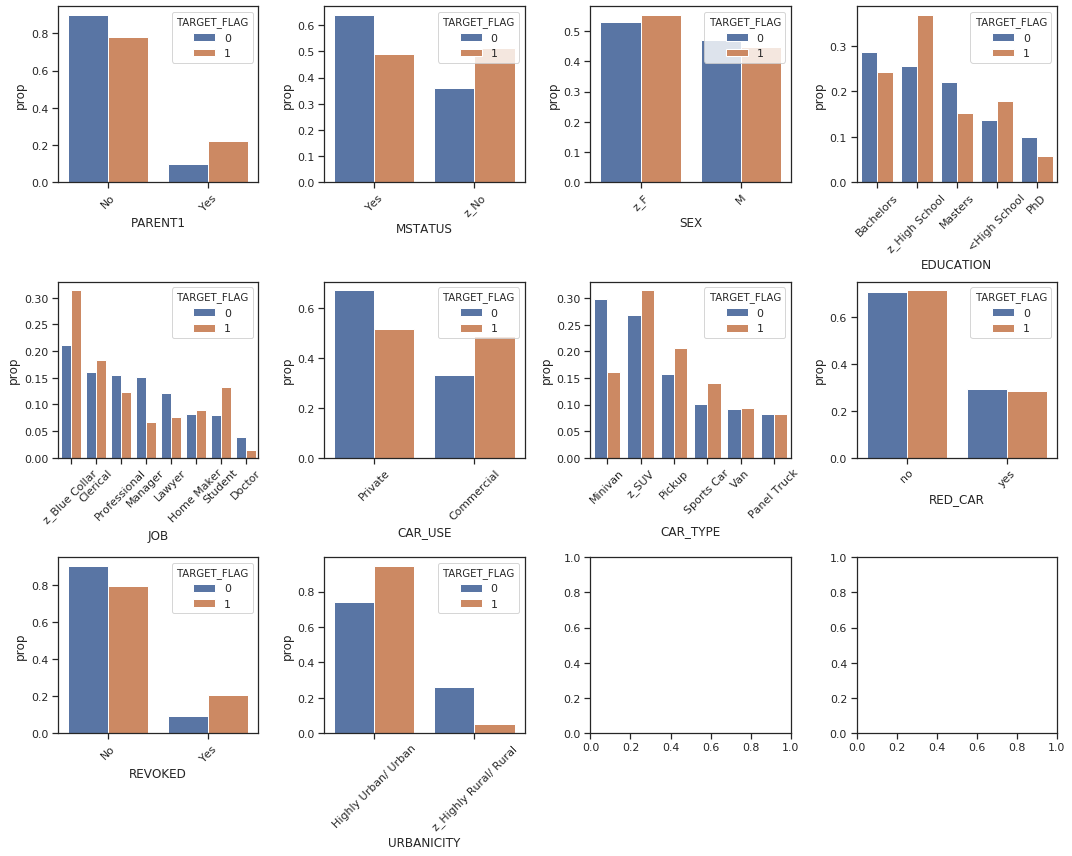

In [8]:
ordinary_columns = data_train.select_dtypes(include = ['O']).columns
plot_cat_distribution(data_train, ordinary_columns)

- La $\textbf{couleur de la voiture}$ et le $\textbf{sexe}$  du client semblent être des variables indépendantes et non corelées à la variable cible
- A l'inverse on peu noter que la $\textbf{zone urbaine}$, le $\textbf{Job}$ et $\textbf{l'utilisation}$ faite de la voiture impactent sur la demande d'indemnisation
- Je vais maintenant faire des analyses sur les variables continues

In [9]:
continuous_columns = [col for col in data_train.columns if\
                      (col not in list(ordinary_columns) + ['TARGET_FLAG'] )]
continuous_columns_1 = ['KIDSDRIV', 'YOJ', 'HOMEKIDS', 'CLM_FREQ', 'MVR_PTS', 'TIF']
continuous_columns_2 = [col for col in continuous_columns if col not in continuous_columns_1]

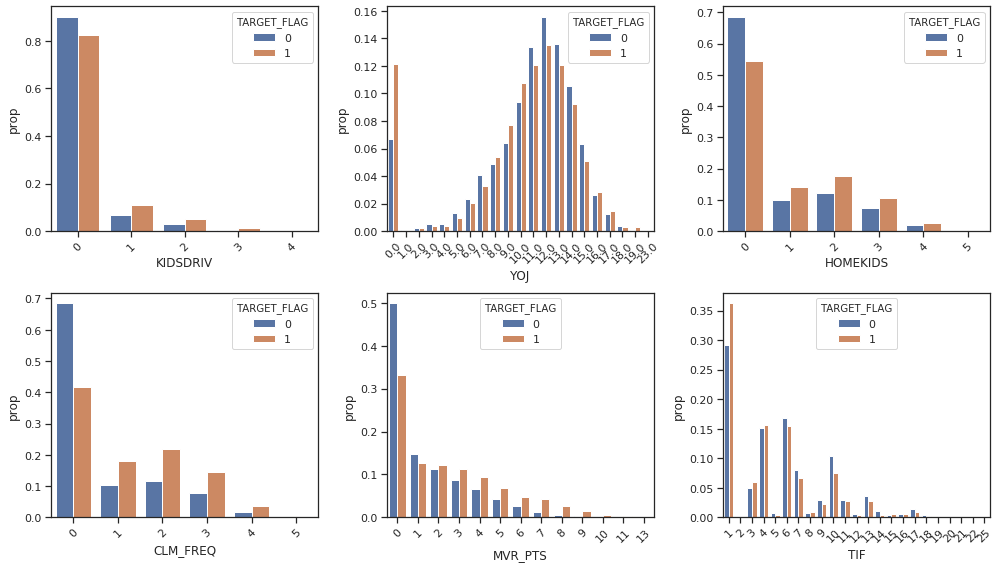

In [10]:
plot_cat_distribution(data_train, continuous_columns_1, 
                      n_left=2, n_right=3, figsize=(14, 8))

Les variables ci-dessus peuvent être considérées comme catégorielles compte tenue le nombre de modalités qu'elles prennent c'est pourquoi j'ai opté pour une méthode d'analyse similaire à celle des variables catégorielles

- CLM_FREQ semble être très informative quand à la demande d'indemnisation

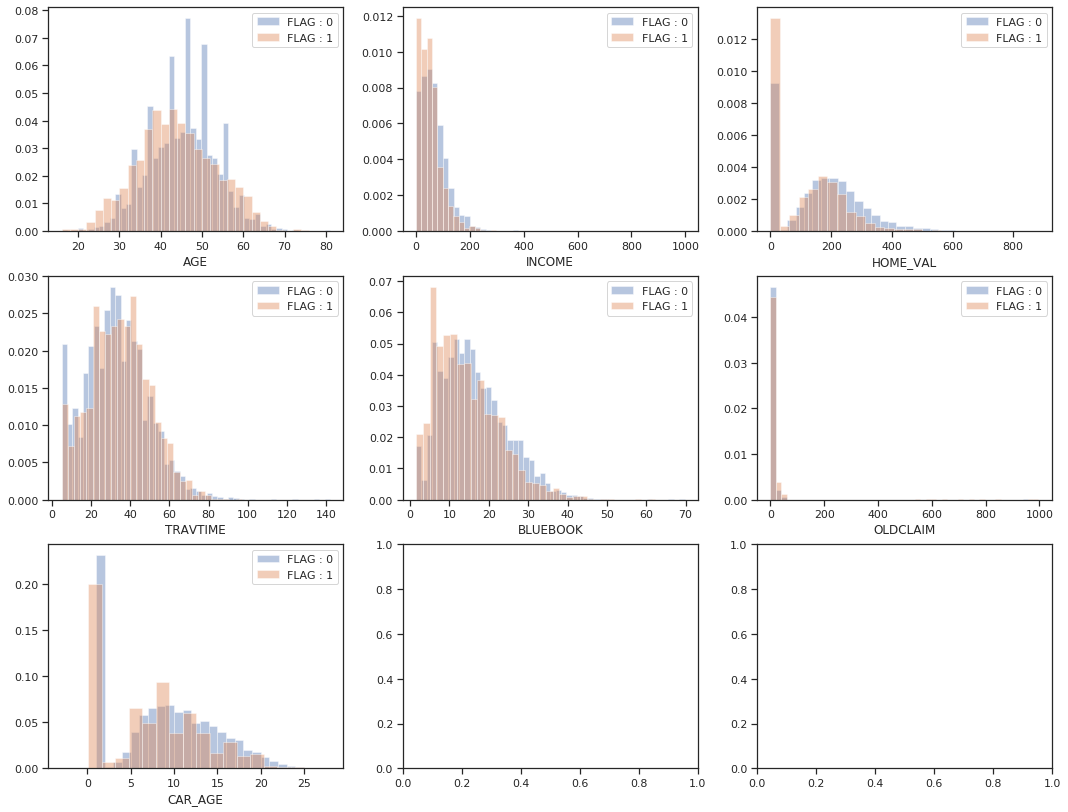

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()
for i, col in enumerate(continuous_columns_2) :
    sns.distplot(data_train[(data_train.TARGET_FLAG == 0) &\
                            (data_train[col].notnull())][col],
                 kde=False, ax=axes[i], norm_hist=True, label='FLAG : 0')
    sns.distplot(data_train[(data_train.TARGET_FLAG == 1) &\
                            (data_train[col].notnull())][col], 
                 kde=False, ax=axes[i], norm_hist=True, label='FLAG : 1')
    axes[i].legend(loc='best')

Pour les variables continues, j'ai fait une analyse via des histogrammes de chaque variable pour chaque classe
- Statistiquement, les assurés en deça de 40 ans, dont l'income est inférieur à 100 ont plus tendance à faire des demandes d'indemnisation

### Gestion des valeurs manquantes

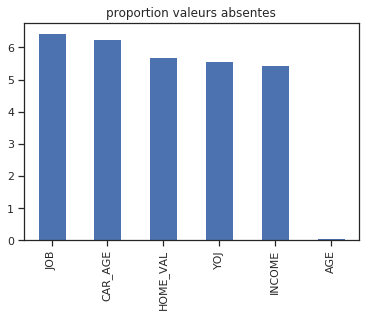

In [12]:
tmp = 100*data_train.isnull().sum()/len(data_train)
(tmp[tmp > 0].sort_values(ascending = False)).plot(kind = 'bar')
plt.title(label = 'proportion valeurs absentes');

 - Au maximum moins de 6% de valeurs absentes pour les variables donc aucunes d'entre elles ne seront supprimées
 - Pour les variables catégorielles (JOB), une nouvelle catégorie Unknow sera créée
 - Les valeurs absentes des variables continues seront simplement remplacées par des valeurs médianes afin de ne pas être trop impacté par les valeurs extrêmes
 - Si l'on dispose d'une segmentation plus fine des clients il serait intéressant d'analyser la valeur ajoutée du remplissage des valeurs manquantes par des moyennes/medianes par segment

In [13]:
data_train['JOB'].fillna("unknow", inplace=True)
for col in ["CAR_AGE", "HOME_VAL", "YOJ", "INCOME", "AGE"] :
    data_train[col].fillna(data_train[col].median(), inplace=True)  

## Modelisation Machine Learning

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [15]:
## Transformation des variables catégorielles en continue
data_train = pd.get_dummies(data_train, columns=ordinary_columns, drop_first=True)

In [16]:
## Séparation train test
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['TARGET_FLAG']), data_train.TARGET_FLAG,
                                                    test_size=0.33, random_state=42, stratify = data_train.TARGET_FLAG)

In [17]:
## Standardization des données, utile pour la plupart des approches
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)

#### Regression Logistique avec penalisation L1

Un recherche par validation croisée sera utilisée pour optimiser l'hyperparamètre lié au coefficient de penalisation

In [18]:
logistic = linear_model.LogisticRegression()
penalty = ['l1']
C = np.logspace(-2, 2, 40)
params = dict(C=C, penalty=penalty, solver=['liblinear'], max_iter=[500])
clf = GridSearchCV(logistic, params, cv=3, scoring='roc_auc', verbose=10, n_jobs = 4)
best_model = clf.fit(X_train_tr, y_train)
print(clf.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1787s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1892s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 103 tasks      | elapsed:    3.0s


{'C': 0.17012542798525893, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.3s finished


Les performances du modèle seront estimées via l'Accuracy et le rappel
- Le rappel est une métrique très importante dans le cas d'une prédiction d'indemnisation. En effet il est plus risqué, à mon sens, de laisser passer un assuré qui va réellement demander une indemnisation que de prédire qu'un assuré va en demander alors qu'il ne le fera pas

In [19]:
y_pred = best_model.predict_proba(X_test_tr)[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)

print("Accuracy", accuracy_score(best_model.predict(X_test_tr), y_test))
print("Rappel", recall_score(best_model.predict(X_test_tr), y_test))

Accuracy 0.781365998515219
Rappel 0.6349557522123894


In [20]:
feature_importance = pd.DataFrame(best_model.best_estimator_.coef_.T)
feature_importance = pd.concat([pd.DataFrame(
    X_train.columns.values), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance['Importance_abs'] = feature_importance.Importance.apply(np.abs)
feature_importance = feature_importance.sort_values(
    by='Importance_abs', axis=0, ascending=False).drop(columns = 'Importance_abs')

In [21]:
feature_importance.head(10)

,Variable,Importance
36,URBANICITY_z_Highly Rural/ Rural,-1.009438
33,CAR_TYPE_z_SUV,0.348558
31,CAR_TYPE_Sports Car,0.309215
28,CAR_USE_Private,-0.305627
23,JOB_Manager,-0.297074
35,REVOKED_Yes,0.239066
8,TIF,-0.226103
11,MVR_PTS,0.223550
6,TRAVTIME,0.216842
30,CAR_TYPE_Pickup,0.191769


Les variables ayant le plus de poids quant à la prédiction de la target semblent être la zone urbaine, le type de voiture et le type de JOB

On retrouve les résultats des analyses faites plus haut

In [22]:
feature_importance.tail(10)

,Variable,Importance
3,YOJ,-0.048910
19,EDUCATION_z_High School,0.047553
22,JOB_Lawyer,-0.045875
21,JOB_Home Maker,-0.016431
12,CAR_AGE,0.015729
9,OLDCLAIM,-0.012159
1,AGE,-0.011699
34,RED_CAR_yes,0.001752
27,JOB_z_Blue Collar,0.000000
25,JOB_Student,0.000000


#### RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf_rf = RandomForestClassifier()
params = {'max_depth' : [45, 50, 60],
          'criterion' : ['entropy', 'gini'],
          'class_weight' : ['balanced'],
          'n_estimators':[100, 150, 200, 250]}
OPT = GridSearchCV(clf_rf, params,
                      cv = 3, scoring='roc_auc', n_jobs=6, verbose = 10)
OPT.fit(X_train, y_train);

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.7s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   20.5s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   23.8s
[Parallel(n_jobs=6)]: Done  69 out of  72 | elapsed:   26.1s remaining:    1.1s
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed:   27.0s finished


In [24]:
print(OPT.best_params_)
print("Accuracy", accuracy_score(OPT.predict(X_test), y_test))
print("Rappel", recall_score(OPT.predict(X_test), y_test))

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 250}
Accuracy 0.7858203414996288
Rappel 0.6914285714285714


- Le RandomForest fournit des performances légèrement meilleures en terme d'accuracy que le LASSO mais l'approche améliore significativement le rappel
- C'est ce modèle que j'appliquerai sur les vraies données test

In [25]:
feature_importance = pd.DataFrame(OPT.best_estimator_.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(
    X_train.columns.values), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance = feature_importance.sort_values(
    by='Importance', axis=0, ascending=False)
feature_importance.head(10)

,Variable,Importance
7,BLUEBOOK,100.000000
4,INCOME,99.212123
6,TRAVTIME,93.239939
5,HOME_VAL,92.177617
1,AGE,85.729976
9,OLDCLAIM,75.874538
36,URBANICITY_z_Highly Rural/ Rural,74.606802
12,CAR_AGE,62.905728
3,YOJ,61.118298
8,TIF,58.540982


- L'attribut feature importance du RF estime que la variable la plus significative est BLUEBOOK
- Un point d'attention à noter est le fait que le feature importance des arbres de décisions favorisent beaucoup plus les variables continues 

## Application du modèle sur les données test

#### Re-entraînement du modèle sur  l'intégralité du set d'entraînement 

In [26]:
clf_rf = RandomForestClassifier()
clf_rf = clf_rf.set_params(**OPT.best_params_) ## Hyperparamètres optimaux estimés précédemment 

X = data_train.drop(columns=['TARGET_FLAG']).values
y = data_train.TARGET_FLAG.values

clf_rf.fit(X, y); ## re-entraînement sur l'intégralité du jeu de données

#### Chargement et preprocessing des données test

In [27]:
data_test = pd.read_csv("test_auto.csv")
index = data_test.INDEX
data_test.drop(columns=["INDEX", "TARGET_AMT"], inplace=True)

for col in ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"] :
    data_test[col] = data_test[col].apply(clean_amount_col)
data_test['JOB'].fillna("unknow", inplace=True)
for col in ["CAR_AGE", "HOME_VAL", "YOJ", "INCOME", "AGE"] :
    data_test[col].fillna(data_train[col].median(), inplace=True) 
data_test = pd.get_dummies(data_test, columns=ordinary_columns, drop_first=True)[data_train.columns]    
X_test = data_test.drop(columns=['TARGET_FLAG']).values   

#### Prédiction et Sauvegarde

In [28]:
y_pred = clf_rf.predict(X_test)

df_result = pd.DataFrame()
df_result["INDEX"] = index
df_result["TARGET_FLAG"] = y_pred

df_result.to_csv("prediction.csv", index=False)